In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d as b3d
import trimesh
import os
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import jit, vmap
import jax.numpy as jnp


key = jax.random.PRNGKey(0)

In [3]:
import traceviz.client
import numpy as np
from traceviz.proto import  viz_pb2

In [4]:
from typing import Any, NamedTuple


Array = np.ndarray | jax.Array
Shape = int | tuple[int, ...]
FaceIndex = int
FaceIndices = Array
Array3      = Array
Array2      = Array
ArrayNx2    = Array
ArrayNx3    = Array

In [5]:
def area_of_triangle(a:Array3, b:Array3, c:Array3=jnp.zeros(3)):

    v = a-c
    w = b-c

    l = jnp.linalg.norm(w)
    h = jnp.linalg.norm(v - jnp.dot(v, w)/l**2*w)
    area = l*h

    return area/2


def _compute_area_and_normal(f:FaceIndex, vertices):
    a = vertices[f[1]] - vertices[f[0]]
    b = vertices[f[2]] - vertices[f[0]]
    area = area_of_triangle(a, b)
    normal = jnp.cross(a,b)
    return area, normal


compute_area_and_normals = jit(vmap(_compute_area_and_normal, (0,None)))

In [6]:
def patch_trimesh(mesh:trimesh.base.Trimesh):
    """
    Return a patched copy of a trimesh object, and 
    ensure it to have a texture and the following attributes:
    - `mesh.visual.uv`
    - `copy.visual.material.to_color`
    """
    patched_mesh = mesh.copy()
    if isinstance(mesh.visual, trimesh.visual.color.ColorVisuals):
        patched_mesh.visual = mesh.visual.to_texture()
    elif isinstance(mesh.visual, trimesh.visual.texture.TextureVisuals):
        pass

    return patched_mesh


def texture_uv_basis(face_idx:Array, mesh):
    return mesh.visual.uv[mesh.faces[face_idx]]


def uv_to_color(uv:ArrayNx2, mesh):
    return mesh.visual.material.to_color(uv)

In [7]:
def barycentric_to_mesh(p:Array3, i:FaceIndex, mesh):
    x = jnp.sum(p[:,None]*mesh.vertices[mesh.faces[i]], axis=0)
    return x


def sample_from_face(key, n, i, mesh):
    _, key = keysplit(key,1,1)
    ps = jax.random.dirichlet(key, jnp.ones(3), (n,)).reshape((n,3,1))
    xs = jnp.sum(ps*mesh.vertices[mesh.faces[i]], axis=1)
    return xs, ps


def sample_from_mesh(key, n, mesh):
    """Returns random points, barycentric coordinates, and face indices from a mesh."""
    key, keys = keysplit(key,1,2)
    areas, _ = compute_area_and_normals(mesh.faces, mesh.vertices)
    fs = jax.random.categorical(keys[0], jnp.log(areas), shape=(n,))
    ps = jax.random.dirichlet(keys[1], jnp.ones(3), (n,)).reshape((n,3,1))
    xs = jnp.sum(ps*mesh.vertices[mesh.faces[fs]], axis=1)
    return xs, ps, fs
    

def get_colors_from_mesh(ps:ArrayNx3, fs:FaceIndices, mesh):
    uvs = jnp.sum(ps * texture_uv_basis(fs, mesh), axis=1)
    cs  = uv_to_color(uvs, mesh)/255
    return cs

In [8]:
help(sample_from_mesh)

Help on function sample_from_mesh in module __main__:

sample_from_mesh(key, n, mesh)
    Returns random points, barycentric coordinates, and face indices from a mesh.



In [9]:
def uniformly_sample_from_mesh(key, n, mesh, with_color=True):
    """Uniformly sample `n` points and optionally their color on the surface from a mesh."""
    key, keys = keysplit(key,1,2)

    areas, _ = compute_area_and_normals(mesh.faces, mesh.vertices)

    # First sample face indices, then sample barycentric coordinates, and
    # finally compute the positions of the points.
    fs = jax.random.categorical(keys[0], jnp.log(areas), shape=(n,))
    ps = jax.random.dirichlet(keys[1], jnp.ones(3), (n,)).reshape((n,3,1))
    xs = jnp.sum(ps*mesh.vertices[mesh.faces[fs]], axis=1)

    if with_color:
        uvs = jnp.sum(ps* texture_uv_basis(fs, mesh), axis=1)
        cs  = uv_to_color(uvs, mesh)/255
    else:
        cs = jnp.full((n,3), 0.5)

    return xs, cs, {"barycentric": ps, "face_idx": fs}

In [10]:
import numpy as np
import trimesh
from jax.scipy.spatial.transform import Rotation as Rot

def covariance_sq_decomposition(Cov):
    """Returns scales and quaternion from covariance matrix."""
    lambdas, Q = jnp.linalg.eig(Cov)
    return jnp.sqrt(lambdas), Rot.from_matrix(Q).as_quat()


In [11]:
# def uniformly_sample_from_mesh(key, n, faces, vertices, texture_uv=None, uv_to_color=None):
#     """Uniformly sample points on the surface from a mesh."""

#     key, keys = keysplit(key,1,2)

#     areas, _ = compute_area_and_normals(faces, vertices)

#     fs = jax.random.categorical(keys[0], jnp.log(areas), shape=(n,))
#     ps = jax.random.dirichlet(keys[1], jnp.ones(3), (n,))
#     xs = jnp.sum(ps[:,:,None]*vertices[faces[fs]], axis=1)

#     if uv_to_color is not None:
#         us = jnp.sum(ps[:,:,None]*texture_uv[faces[fs]], axis=1)
#         cs = uv_to_color(us)/255
#     else:
#         cs = None

#     return xs, cs, {"barycentric": ps, "face_idx": fs}

https://sketchfab.com/search?features=animated&q=tree&type=models
https://sketchfab.com/3d-models/rigged-animated-cinematic-quality-tree-4-544329bb254d4e45b5eae96ccc5bacf6

In [12]:
!pwd

/home/mirko/workspace/bayes3d/scripts/_mkl/notebooks


## Load Mesh

In [116]:
t=0
mesh = trimesh.load(f"data/flag_objs/flag_t_{t}.obj")

In [13]:
_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

_meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    _meshes.append(mesh)


mesh_path = os.path.join(b3d.utils.get_assets_dir(), "sample_objs/cube.obj")
mesh = trimesh.load(mesh_path)
mesh.vertices *= 1e-1
_meshes.append(mesh)


In [14]:
mesh = _meshes[9] # banana 9, scissors 16

## Fit GMM

In [15]:
mesh = patch_trimesh(mesh)


print(f"""
 mesh.vertices: {mesh.vertices.shape}
    mesh.faces: {mesh.faces.shape}
       mesh.uv: {mesh.visual.uv.shape}
""")


 mesh.vertices: (10710, 3)
    mesh.faces: (15728, 3)
       mesh.uv: (10710, 2)



In [16]:
key = keysplit(key)
n = 20_000
xs, cs, _ = uniformly_sample_from_mesh(key, n, mesh, with_color=True)

2023-11-21 15:12:24.255167: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.93GiB (rounded to 3145600256)requested by op 
2023-11-21 15:12:24.255314: W external/tsl/tsl/framework/bfc_allocator.cc:497] ********************************************________________________________________________________
2023-11-21 15:12:24.255466: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2716] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3145600256 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         8B
              constant allocation:         0B
        maybe_live_out allocation:    1.17GiB
     preallocated temp allocation:    2.93GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    4.10GiB
              total fragmentation:  599.98MiB (14.29%)
Peak buffers:
	Buffer 1:
		Size: 1.17GiB
	

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 3145600256 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:         8B
              constant allocation:         0B
        maybe_live_out allocation:    1.17GiB
     preallocated temp allocation:    2.93GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    4.10GiB
              total fragmentation:  599.98MiB (14.29%)
Peak buffers:
	Buffer 1:
		Size: 1.17GiB
		Operator: op_name="jit(_gumbel)/jit(main)/neg" source_file="/var/tmp/ipykernel_2510908/1262146475.py" source_line=9
		XLA Label: fusion
		Shape: f32[314560000]
		==========================

	Buffer 2:
		Size: 599.98MiB
		Operator: op_name="jit(_gumbel)/jit(main)/jit(_uniform)/threefry2x32" source_file="/var/tmp/ipykernel_2510908/1262146475.py" source_line=9
		XLA Label: custom-call
		Shape: u32[157280000]
		==========================

	Buffer 3:
		Size: 599.98MiB
		Operator: op_name="jit(_gumbel)/jit(main)/jit(_uniform)/threefry2x32" source_file="/var/tmp/ipykernel_2510908/1262146475.py" source_line=9
		XLA Label: custom-call
		Shape: u32[157280000]
		==========================

	Buffer 4:
		Size: 599.98MiB
		Operator: op_name="jit(_gumbel)/jit(main)/jit(_uniform)/slice[start_indices=(157280000,) limit_indices=(314560000,) strides=None]" source_file="/var/tmp/ipykernel_2510908/1262146475.py" source_line=9
		XLA Label: fusion
		Shape: u32[157280000]
		==========================

	Buffer 5:
		Size: 599.98MiB
		Operator: op_name="jit(_gumbel)/jit(main)/jit(_uniform)/slice[start_indices=(0,) limit_indices=(157280000,) strides=None]" source_file="/var/tmp/ipykernel_2510908/1262146475.py" source_line=9
		XLA Label: fusion
		Shape: u32[157280000]
		==========================

	Buffer 6:
		Size: 599.98MiB
		Operator: op_name="jit(_gumbel)/jit(main)/jit(_uniform)/threefry2x32" source_file="/var/tmp/ipykernel_2510908/1262146475.py" source_line=9
		XLA Label: fusion
		Shape: u32[157280000]
		==========================

	Buffer 7:
		Size: 16B
		Operator: op_name="jit(_gumbel)/jit(main)/jit(_uniform)/threefry2x32" source_file="/var/tmp/ipykernel_2510908/1262146475.py" source_line=9
		XLA Label: fusion
		Shape: (u32[157280000], u32[157280000])
		==========================

	Buffer 8:
		Size: 16B
		Operator: op_name="jit(_gumbel)/jit(main)/jit(_uniform)/threefry2x32" source_file="/var/tmp/ipykernel_2510908/1262146475.py" source_line=9
		XLA Label: custom-call
		Shape: (u32[157280000], u32[157280000])
		==========================

	Buffer 9:
		Size: 8B
		Entry Parameter Subshape: u32[2]
		==========================



In [ ]:
jnp.max(xs, axis=0) - jnp.min(xs, axis=0)

Array([0.10881377, 0.17832696, 0.0365523 ], dtype=float32)

In [ ]:
 import numpy as np
from sklearn.mixture import GaussianMixture

key = keysplit(key)
sig = 0.0; 
# sig = 2*1e-3;
n_components = 50
means_init = np.array(uniformly_sample_from_mesh(key, n_components, mesh, with_color=False)[0]);
X = xs + np.random.randn(*xs.shape)*sig
# gm = GaussianMixture(n_components=n_components, tol=1e-3, max_iter=100, covariance_type="spherical").fit(X)
gm = GaussianMixture(n_components=n_components, tol=1e-3, max_iter=100, covariance_type="full", means_init=means_init).fit(X)
gm.means_.shape
vs = gm.score_samples(X)

gm.converged_

True

In [42]:
gm.n_components

50

In [43]:
def get_cluster_counts(n, labels):
    nums = []
    for label in range(n):
        idx = labels == label
        nums.append(np.sum(idx))
    return np.array(nums)

In [44]:
def get_colors(xs, cs, n, labels):
    colors = []
    nums   = []
    for label in range(n):
        idx = labels == label
        nums.append(np.sum(idx))
        colors.append(cs[idx])
    return colors, np.array(nums)

In [45]:
def get_mean_colors(xs, cs, n, labels):
    mean_colors = []
    nums        = []
    for label in range(n):
        idx = labels == label
        nums.append(np.sum(idx))
        if np.sum(idx) == 0: 
            mean_colors.append(np.array([0.5,0.5,0.5, 0.0]))
        else:                
            mean_colors.append(np.mean(cs[idx], axis=0))
    return np.array(mean_colors), np.array(nums)
    

## Visualize

In [46]:
import json

In [47]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  listener_identifiers: "2023-11-21T12:57:37.975145 :: ipv4:127.0.0.1:55110"



In [48]:
def covariance_sq_decomposition(Cov):
    """Returns scales and quaternion from covariance matrix."""
    lambdas, Q = jnp.linalg.eigh(Cov)
    return jnp.sqrt(lambdas), Rot.from_matrix(Q).as_quat()


def ellipsoid_embedding(Cov):
    """Returns A with cov = A@A.T"""
    sigma, U = jnp.linalg.eigh(Cov)
    D = jnp.diag(jnp.sqrt(sigma))
    return U @ D @ jnp.linalg.inv(U)


In [49]:
mus  = gm.means_
covs = gm.covariances_
choleskys = vmap(ellipsoid_embedding)(gm.covariances_)

mean_colors, nums = get_mean_colors(X, cs, gm.n_components, gm.predict(X))
mean_colors.shape, nums.shape

((50, 4), (50,))

In [50]:
lambdas, Q = jnp.linalg.eigh(covs[0])
Q@Q.T

Array([[ 9.9999982e-01,  4.4703484e-08, -1.2805685e-09],
       [ 4.4703484e-08,  1.0000001e+00,  1.8626451e-09],
       [-1.2805685e-09,  1.8626451e-09,  1.0000000e+00]], dtype=float32)

In [51]:
def pack_transform(x, A, scale=1.0):
    B = scale*A
    return jnp.array([
        [B[0,0], B[0,1], B[0,2], x[0]], 
        [B[1,0], B[1,1], B[1,2], x[1]],
        [B[2,0], B[2,1], B[2,2], x[2]],
        [0.0, 0.0, 0.0, 1.0]
    ]).T

transforms = vmap(pack_transform, (0,0,None))(mus, choleskys, 2.0)

In [ ]:
jnp.savez("data/gaussians_banana.npz", mus=mus, covs=covs, choleskys=choleskys, mean_colors=mean_colors, nums=nums)

In [1]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "Gaussians2"})
msg.payload.data.MergeFrom(
    traceviz.client.to_pytree_msg({
        'transforms': np.array(transforms )[nums>0], 
        'colors':     np.array(mean_colors)[nums>0]  
    })
)
    
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


NameError: name 'viz_pb2' is not defined

In [232]:
msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "setup"})
msg.payload.data.MergeFrom(traceviz.client.to_pytree_msg([]))
stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


response:  listener_identifiers: "2023-11-15T14:39:07.745000 :: ipv4:127.0.0.1:48652"



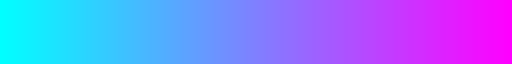

In [233]:


cm  = getattr(plt.cm, "cool")
# cs  = cm(plt.Normalize()(vs_))
cm

In [171]:
key = keysplit(key)
xs_, cs_, _ = uniformly_sample_from_mesh(key, 15_000, mesh.faces, mesh.vertices, 
                texture_uv=texvis.uv, uv_to_color=texvis.material.to_color)

# labels_ = gm.predict(xs_)
# cols_ = mean_colors[labels_]
# cs_.shape, cols_.shape



# distances = np.linalg.norm(cs_ - cols_, axis=1)
# print(distances.shape)
# print(np.min(distances), np.max(distances))
# cs_  = cm(plt.Normalize()(distances))
# cs_.shape

NameError: name 'texvis' is not defined

In [148]:


print(xs_.shape, cs_.shape)


msg = viz_pb2.Message()
msg.payload.json = json.dumps({"type": "Spheres"})
msg.payload.data.MergeFrom(
    traceviz.client.to_pytree_msg({
        'centers': np.array(xs_), 
        'colors': np.array(cs_), 
        "scales": 0.025*np.ones(len(xs_))
    })
)
    

stub = traceviz.client.connect()
print('response: ', stub.Broadcast(msg))


NameError: name 'xs_' is not defined